- Imdb yorumlarinin pozitif ve negatif durumunu inceleme, herhangi bir film yorumu yapıldığında bunun pozitif mi negatif mi olduğunu tahmin eden modeller
- Amaç NLP ön işleme tekniklerine hakim olmak.

- veri seti incelemesi
- dataframe üzerinde metin ön işleme süreçleri
- wordcloud
- Lemmatization / Stemming
- işlenmiş veriyi modele uygun bölme
- model eğitme
- görselleştirme
- accuracy/precision/recall/f1 değerlerinin incelenmesi


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from timeit import default_timer as timer
from datetime import timedelta
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize

import warnings
warnings.filterwarnings("ignore") 

In [5]:
df = pd.read_csv("IMDB Dataset.csv")

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [96]:
len(df["sentiment"])

50000

In [7]:
df["review"].iloc[:20]

0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
2     I thought this was a wonderful way to spend ti...
3     Basically there's a family where a little boy ...
4     Petter Mattei's "Love in the Time of Money" is...
5     Probably my all-time favorite movie, a story o...
6     I sure would like to see a resurrection of a u...
7     This show was an amazing, fresh & innovative i...
8     Encouraged by the positive comments about this...
9     If you like original gut wrenching laughter yo...
10    Phil the Alien is one of those quirky films wh...
11    I saw this movie when I was about 12 when it c...
12    So im not a big fan of Boll's work but then ag...
13    The cast played Shakespeare.<br /><br />Shakes...
14    This a fantastic movie of three prisoners who ...
15    Kind of drawn in by the erotic scenes, only to...
16    Some films just simply should not be remade. T...
17    This movie made it into one of my top 10 m

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\menes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\menes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\menes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\menes\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
metin_list = df["review"].tolist()
metin_list

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [12]:
print(type(metin_list))

<class 'list'>


In [13]:
print(len(metin_list))

50000


In [14]:
wc = "".join(str(i) for i in metin_list)

In [16]:
wc[:20]

'One of the other rev'

In [22]:
from wordcloud import WordCloud

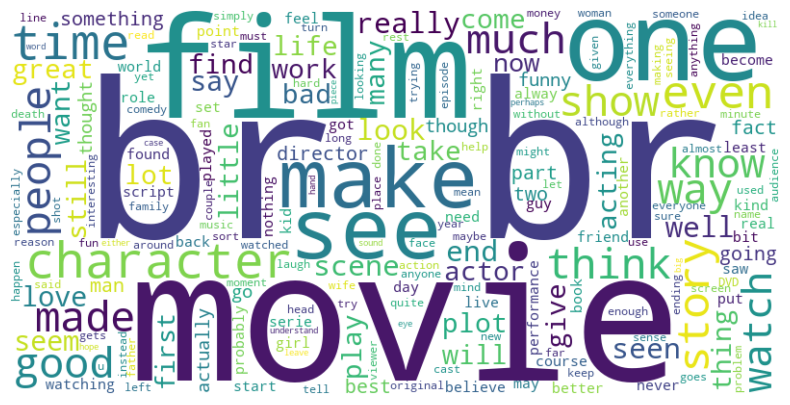

In [23]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Metinleri temizleme

In [25]:
type(df["review"])

pandas.core.series.Series

In [33]:
metin = df["review"]

In [34]:
def metin_isleme(series):
    try:
        print("Küçük harfe çeviriliyor...")
        print("Hashtagler kaldırılıyor...")
        print("Mentionlar kaldırılıyor...")
        print("Linkler kaldırılıyor...")
        print("Sayılar kaldırılıyor...")
        print("Removing stopwords...")
        print("Noktalama işaretleri kaldırılıyor...")
        print("Nadir kelimeler kaldırılıyor...")
        print("Kısa metinler kaldırılıyor...")
        series = series.str.lower()
        series = series.str.replace(r'((#)[^\s]*)\b', '', regex=True)       
        series = series.str.replace(r'((@)[^\s]*)\b', '', regex=True)   
        series = series.str.replace(r'\n', '', regex=True)
        series = series.apply(lambda x: re.split('https:\/\/.*', str(x))[0])
        series = series.str.replace(r'\d+', '', regex=True)
        stop_words = set(stopwords.words('english'))
        series = series.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
        whole_count = pd.Series(" ".join(series).split()).value_counts()
        to_remove = whole_count[whole_count <= 3]
        series = series.apply(lambda x: " ".join(x for x in x.split() if x not in to_remove))
        series = series.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))
        series = series.str.replace(r"((')[^\s]*)\b", '', regex=True)
        series = series.str.replace(r'[^\w\s]', '', regex=True)
    except IndexError as err:
        print(err)
    return series

In [35]:
df["islenmis"] = metin_isleme(metin)

Küçük harfe çeviriliyor...
Hashtagler kaldırılıyor...
Mentionlar kaldırılıyor...
Linkler kaldırılıyor...
Sayılar kaldırılıyor...
Removing stopwords...
Noktalama işaretleri kaldırılıyor...
Nadir kelimeler kaldırılıyor...
Kısa metinler kaldırılıyor...


In [36]:
df.head()

,review,sentiment,islenmis
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching episode hook...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy thinks there...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,mattei love time money visually stunning film ...


In [43]:
pd.set_option('display.max_colwidth', None)
df[["review","islenmis"]].head(20)

,review,islenmis
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",one reviewers mentioned watching episode hooked right exactly happened the first thing struck brutality unflinching scenes violence set right word trust show faint hearted show pulls punches regards drugs sex violence hardcore classic use word called nickname given oswald maximum security state focuses mainly emerald city experimental section prison cells glass fronts face privacy high agenda city home muslims latinos christians italians irish death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget mess around first episode ever saw struck nasty surreal say ready watched more developed taste got accustomed high levels graphic violence violence injustice guards who sold inmates who kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching may become comfortable uncomfortable get touch darker side
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",wonderful little production the filming technique fashion gives comforting sometimes sense realism entire piece the actors extremely well michael sheen has got voices pat too truly see seamless editing guided

In [45]:
pd.reset_option('display.max_colwidth')

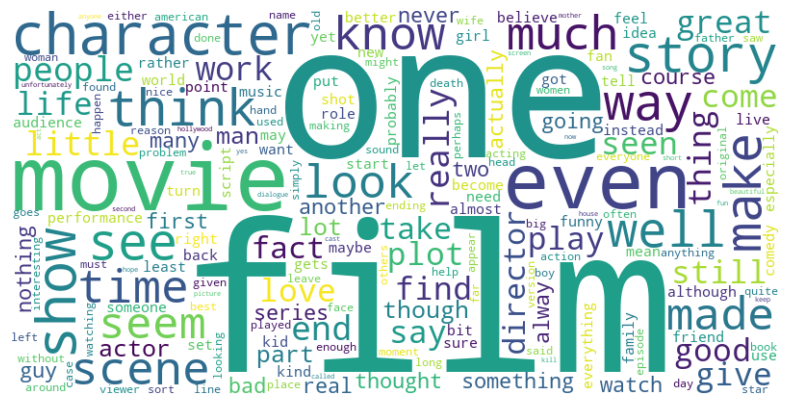

In [47]:
islenmis_list = df["islenmis"].to_list()
wc = "".join(str(i) for i in islenmis_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Lemma

In [53]:

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    kelimeler = word_tokenize(text)
    pos_kelimeler = pos_tag(kelimeler)  
    lemmatized_words = []
    for kelime, pos in pos_kelimeler:
        if pos.startswith('V'): 
            pos = 'v'
        elif pos.startswith('N'):  
            pos = 'n'
        elif pos.startswith('J'):  
            pos = 'a'
        else:
            pos = 'n'  
        
        lemmatized_words.append(lemmatizer.lemmatize(kelime, pos))
    
    return ' '.join(lemmatized_words)

df['lemmatized'] = df['islenmis'].apply(lemmatize_text)


df.head()

,review,sentiment,islenmis,lemmatized
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching episode hook...,one reviewer mention watch episode hook right ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production the filming tech...,wonderful little production the filming techni...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,basically there family little boy thinks there...,basically there family little boy think there ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,mattei love time money visually stunning film ...,mattei love time money visually stunning film ...


In [54]:
df[["islenmis","lemmatized"]]

,islenmis,lemmatized
0,one reviewers mentioned watching episode hook...,one reviewer mention watch episode hook right ...
1,wonderful little production the filming tech...,wonderful little production the filming techni...
2,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...
3,basically there family little boy thinks there...,basically there family little boy think there ...
4,mattei love time money visually stunning film ...,mattei love time money visually stunning film ...
...,...,...
49995,thought movie right good job creative original...,think movie right good job creative original f...
49996,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad act idiotic direct a...
49997,catholic taught parochial elementary schools n...,catholic teach parochial elementary school nun...
49998,going disagree previous comment side maltin o...,go disagree previous comment side maltin one s...


### Model

In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [63]:
df.head()

,review,sentiment,islenmis,lemmatized
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching episode hook...,one reviewer mention watch episode hook right ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production the filming tech...,wonderful little production the filming techni...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,basically there family little boy thinks there...,basically there family little boy think there ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,mattei love time money visually stunning film ...,mattei love time money visually stunning film ...


In [64]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])
df.head()

,review,sentiment,islenmis,lemmatized,label
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching episode hook...,one reviewer mention watch episode hook right ...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production the filming tech...,wonderful little production the filming techni...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...,1
3,Basically there's a family where a little boy ...,negative,basically there family little boy thinks there...,basically there family little boy think there ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,mattei love time money visually stunning film ...,mattei love time money visually stunning film ...,1


In [65]:
X = df['lemmatized'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [94]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

for model_name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    print(model_name)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n" + "-"*40 + "\n")


Logistic Regression
Accuracy: 0.8862
Precision: 0.8776379477250726
Recall: 0.8995832506449692
F1 Score: 0.8884751078008624

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


----------------------------------------

XGBoost
Accuracy: 0.8529
Precision: 0.8407181054239877
Recall: 0.8735860289740027
F1 Score: 0.8568369829683699

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4961
           1       0.84      0.87      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


--------------------

In [124]:
text = "The movie is good!"
lemma_text = lemmatize_text(text)
vec = vectorizer.transform([lemma_text])
pred_ = model.predict(vec)
## son model random forest olduğu için %85 acc değerine sahip model üzerinden test etmiş olduk.

In [126]:
print(f"Prediction: {pred_}")

if pred_ == 1:
    print("The sentiment is positive!")
else:
    print("The sentiment is negative!")

Prediction: [1]
The sentiment is positive!
